# Demo of `SpatialReference` class

### why
Most models require spatially-distributed data, and their results are more meaningful when plotted on a map.

### purpose of class:
* lightweight (doesn't take minutes to load) representation of model grid in geographic coordinates for relating the model to external data
* transformations between model coordinates and geographic coorindates*
* convenience methods for mapping geographic data to a model grid and model results to geographic coordinates

### design paradigms
* stand-alone (can be instantiated by itself without flopy model object or any other class instances)
* key attributes (cell centers, edges, vertices, etc.) are decorated as properties, allowing for them to be updated dynamically (after instantiation of the class)
* attribute properties are cached in private attributes to improve performance when they are accessed repeatedly with their dependencies unchanged. (for example, multiple calls to `.vertices`, with the same grid spacing, origin, rotation and length units)

***Note:** the term "geographic" is used loosely here to denote any coordinate system that can locate something on earth. Mostly we are talking about projected coordinate systems that have a length unit of meters, such as UTM.

In [1]:
import os
import numpy as np
from flopy.grid import StructuredModelGrid
from flopy.grid import SpatialReference
from flopy.utils import SpatialReference as OGsr
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
tmpdir = 'tmp'
if not os.path.isdir(tmpdir):
    os.makedirs(tmpdir)

### Make a spatial reference object
* the sr provides transformations from an attached grid class (`.modelgrid` attribute)
* modelgrid can be supplied as an argument or created from supplied delr and delc arrays, as [in the existing version of `SpatialReference`](https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_SpatialReference_demo.ipynb)

In [3]:
sr = SpatialReference(delc=np.ones(10), delr=np.ones(10),
                      xll=10, yll=10, rotation=20,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )
sr.modelgrid

### the key method is `.transform()`
* performs all transformations between model and geographic coordinates, by applying rotation, scaling (e.g. feet vs. meters) and offset.
* takes x and y locations as arguments
* default is from model coordinates to real or geographic coordinates
* an `inverse` argument allows for transformation of geographic coordinates to model coordinates

In [4]:
sr.transform(10, 10)

(11.82170571129881, 13.906660505012088)

In [5]:
sr.transform(11.82170571129881, 13.906660505012088, inverse=True)

(9.999999999999995, 10.000000000000005)

## key attributes

### cell center and edge (or corner) coordinates
* the `.*centers` and `.*edges` attributes return 2d (nrow, ncol) numpy arrays for easy indexing
    * (these attributes are named `.*centergrid` and `.*grid` in current SR class)
* the underlying `ModelGrid`-based class as the same attributes, providing untransformed locations
* all of the key attributes work with scalars, lists, or numpy arrays

In [6]:
sr.xcenters[1, 7] # x-coordinate at row 1, column 7

11.262031543788444

In [7]:
sr.xcenters[[1, 3], [7, 7]]

array([11.26203154, 11.47052702])

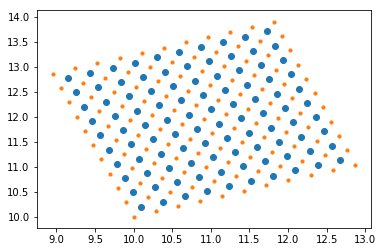

In [8]:
plt.scatter(sr.xcenters.ravel(), sr.ycenters.ravel())
plt.scatter(sr.xedges.ravel(), sr.yedges.ravel(), s=10)

### center and edge attributes for underlying model grid
in the model coordinate system with an origin at the upper left corner.

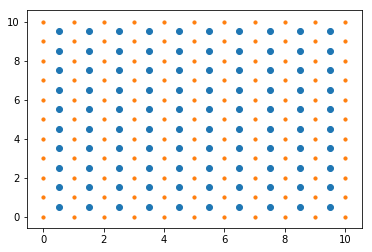

In [9]:
plt.scatter(sr.modelgrid.xcenters.ravel(), sr.modelgrid.ycenters.ravel())
plt.scatter(sr.modelgrid.xedges.ravel(), sr.modelgrid.yedges.ravel(), s=10)

### Grid lines

(`.get_gridlines()` in the current SR class)

In [10]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]])

(11, -1)

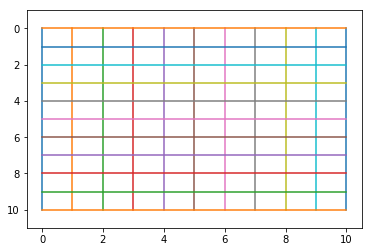

In [11]:
plot_lines(sr.modelgrid.gridlines)
plt.ylim(11, -1)

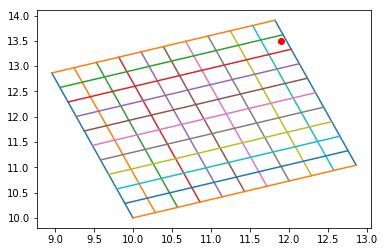

In [12]:
plot_lines(sr.gridlines)
plt.scatter(11.9, 13.5, c='r')

### cell vertices

In [13]:
sr.modelgrid.vertices[0]

[[0.0, 10.0], [0.0, 9.0], [1.0, 9.0], [1.0, 10.0], [0.0, 10.0]]

In [14]:
sr.vertices[0]

[[8.957522603143362, 12.864183108155448],
 [9.061770342829025, 12.577764797339904],
 [9.34818865364457, 12.68201253702557],
 [9.243940913958907, 12.968430847841113],
 [8.957522603143362, 12.864183108155448]]

(0, 24)

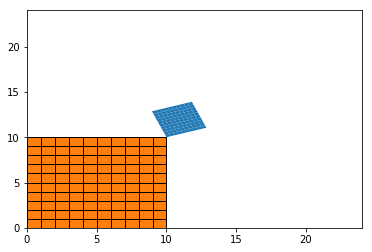

In [15]:
from flopy.utils.geometry import Polygon
from matplotlib.collections import PatchCollection

sr_patches = [Polygon(v).patch for v in sr.vertices]
mg_patches = [Polygon(v).patch for v in sr.modelgrid.vertices]
fig, ax = plt.subplots()
ax.add_collection(PatchCollection(sr_patches))
ax.add_collection(PatchCollection(mg_patches, color='C1', edgecolor='k'))
ax.set_xlim(0, 24)
ax.set_ylim(0, 24)

## Applications

### get the row column index of a location in geographic coordinates
(e.g. for setting up observation data)

In [16]:
sr.get_rc(11.9, 13.5)

(1, 9)

In [17]:
datadir = '../data/br/dem.tif'

### Sample data from a raster

In [18]:
from flopy.utils.preprocessing import get_values_at_points
from matplotlib.colors import LightSource
ls = LightSource(azdeg=315, altdeg=45)


##### make another sr

In [19]:
nrow, ncol = 300, 500
dxy = 100 # feet (model coordinates)
xll = 680500
yll = 5137500
rotation = 0.

sr = SpatialReference(delc=np.ones(nrow)*dxy, delr=np.ones(ncol)*dxy,
                      xll=xll, yll=yll, rotation=rotation,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )
sr

xul:680500; yul:5146644; rotation:0; proj4_str:+proj=utm +zone=15 +ellps=clrk66 +datum=NAD27 +units=m +no_defs ; units:meters; lenuni:1; length_multiplier:0.3048

### the `sample()` method returns the values of raster pixels closest to cell centers (newly implemented)
* could be easily extended to do zonal statistics instead
* requires the python `gdal` bindings, which come with `conda install rasterio`

In [20]:
elevations = sr.sample('../data/br/dem.tif')

reading data from ../data/br/dem.tif...
sampling...
finished in 0.02s


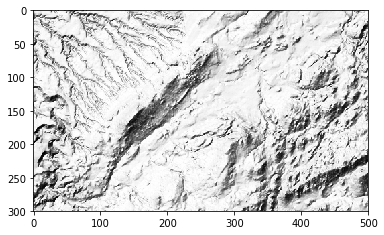

In [21]:
plt.imshow(ls.hillshade(elevations), cmap='Greys_r')

### the `intersect()` method intersects vector features with the model grid (newly implemented)
* takes a shapefile, list of `flopy.utils.geometry` features, or dataframe with `geometry` column (as you would get with `flopy.utils.shapefile_utils.shp2recarray`. (`shapely` objects could easily be supported as well)
* `id_column` argument allows the numerical value for each feature to be specified; default is the feature index position
* uses `rasterio`

##### limitations
* right now the shapefile must be in the same CRS as the sr, but reprojection could be easily supported with the user supplying a proj4 string or epsg code
* with the `fiona` package as an option dependency, reprojection wouldn't require any additional user input, as long as there was a .prj file.
* currently only rasterization is supported, where only a single feature is intersected with each cell, if the cell centroid is within that feature (I'm guessing the ordering is based on feature index position)
* a more sophisticated spatial join option could be implemented, but would require the `shapely` and `rtree` packages, or maybe just `geopandas`, which [looks to be gaining some steam](http://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1), and can be easily installed from conda forge. Spatial join is generally required for more sophisticated tasks like building the stream network, and would also be required for unstructured grids.

In [22]:
results = sr.intersect('../data/br/catchments.shp')

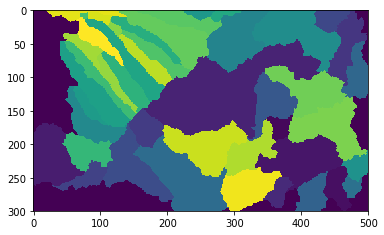

In [23]:
plt.imshow(results)

### `interpolate()` for resampling a grid (existing method)
* uses `scipy.griddata`

##### for example, transfering information to an inset model

In [24]:
# make an inset model
nrow, ncol = 200, 300
dxy = 50 # feet (model coordinates)
xll = 683000
yll = 5138000
rotation = 30.

sr2 = SpatialReference(delc=np.ones(nrow)*dxy, delr=np.ones(ncol)*dxy,
                      xll=xll, yll=yll, rotation=rotation,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )

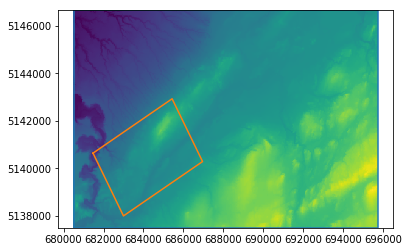

In [25]:
outline1 = np.array(sr.outline).transpose()
outline2 = np.array(sr2.outline).transpose()
plt.plot(outline1[0], outline1[1])
plt.plot(outline2[0], outline2[1])
plt.pcolormesh(sr.xcenters, sr.ycenters, elevations, zorder=-1)

In [26]:
interp = sr.interpolate(elevations, (sr2.xcenters, sr2.ycenters))
interp.shape

(200, 300)

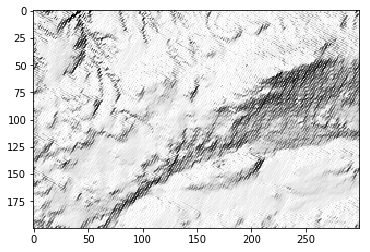

In [27]:
plt.imshow(ls.hillshade(interp), cmap='Greys_r')

### exporting model information to GIS file formats (existing methods)
* this provides an alternative for model visualization to the `.plot()` methods, which many users may find too cumbersome for larger models

##### simple shapefile of just the grid cells with node number, row and column
* this could easily be extended to allow general exporting of any numerical data mapped to the model grid, similar to `export_array`, but without the requirement of a regular grid

In [28]:
sr2.write_shapefile('{}/sr2.shp'.format(tmpdir))

wrote tmp/sr2.shp


##### GeoTIFF of any array that maps to the sr
* can do arc-ascii grid format too but GeoTIFFs are better because they include a full coordinate reference, are faster to read and write, and use much less disk space (esp. with compression)
* uses `rasterio`
* GeoTIFFs only work for a structured grid with uniform cell size, but allow for rotation and multiple bands (i.e., a 3d numpy array can be written to a single file, with each layer occupying a band)

In [29]:
sr2.export_array('{}/inset_elevations.tif'.format(tmpdir), interp)

wrote tmp/inset_elevations.tif


##### shapefile of array contours

In [30]:
levels = np.linspace(np.round(interp.min(), -1),
                     np.round(interp.max(), -1))
sr2.export_array_contours('{}/inset_elev_contours.shp'.format(tmpdir), interp, levels=levels)

wrote tmp/inset_elev_contours.shp


## `SpatialReference` I/O

The current paradigm is to store spatial reference information in the header comments for the MODFLOW `.nam` file. With a `DIS` package, this provides enough information to create a `SpatialReference` instance. 

However, an alternative format that can completely describe a `SpatialReference` object would allow the user to create a spatial reference without taking the time to load a model (even loading just the `DIS` package can be slow for larger models). This also allows for experimenting with different grids without constructing a model.

##### currently, read/writing of the PEST-style grid specification file is supported
* the grid spec format includes an offset and rotation, but no information about scaling or the CRS

In [31]:
sr2.write_gridSpec('{}/sr2.spc'.format(tmpdir))

wrote tmp/sr2.spc


In [32]:
with open('tmp/sr2.spc') as input:
    for i in range(2):
        print(next(input))
    print(next(input)[:200])
    print(next(input)[:200])

       200        300

   2.077139E+05    1.566867E+06    3.000000E+01

   5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000
   5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000000E+01    5.000


##### the USGS Office of Groundwater `usgs.model.reference` format can also be read, but does not contain information about the actual cell geometries 
(number of rows and columns and cell spacings for a structured grid)

### Example of a JSON file format that completely describes a spatial reference
* for non-uniform structured grids, delc and delr could be stored and read in as lists
* unstructured grids could be also be stored as lists, or the [GeoJSON](http://geojson.org/) format could be used to store any kind of geometric object

In [33]:
sr.write_json('{}/sr.json'.format(tmpdir))

wrote tmp/sr.json


In [34]:
with open('{}/sr.json'.format(tmpdir)) as src:
    print(src.read())

{
    "delc": 100.0,
    "delr": 100.0,
    "epsg": 26715,
    "length_multiplier": 0.3048,
    "lenuni": 1,
    "ncol": 500,
    "nrow": 300,
    "proj4_str": "+proj=utm +zone=15 +ellps=clrk66 +datum=NAD27 +units=m +no_defs ",
    "rotation": 0.0,
    "xul": 680500.0,
    "yul": 5146644.0
}


In [35]:
SpatialReference.from_json('{}/sr.json'.format(tmpdir))

xul:680500; yul:5146644; rotation:0; proj4_str:+proj=utm +zone=15 +ellps=clrk66 +datum=NAD27 +units=m +no_defs ; units:meters; lenuni:1; length_multiplier:0.3048

In [36]:
SpatialReference.from_json('{}/sr.json'.format(tmpdir)) == sr

True

## conversion between projected coordinates and latitude and longitude (not implemented yet)

Using `pyproj`, easy conversion to and from latitude and longitude could be easily added to `SpatialReference`, via a `project()` or `to_latlon()` method. The above properties for the cell centers, edges and vertices could be made accessible for plotting via an `.ll` attribute class. 

For example, to get the cell center x-coordinates, instead of `.xcenters`, one would call `.ll.xcenters`